In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis, sklearn.linear_model
import time
import scipy.stats
import copy

root = '/usr/local/serenceslab/maggie/shapeDim/'

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils
from code_utils import decoding_utils
from code_utils import stats_utils, plot_utils


In [2]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 7
subjects = np.arange(1,8)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [3]:
lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)
   

In [4]:
from code_utils import grid_utils
grid_pts = grid_utils.get_main_grid()
# NOTE i am swapping the columns here
# because this is the order you get from doing np.unique(pts)
# this is the actual order that the predictions 1-16 of this classifier
# correspond to. 
grid_pts = grid_pts[:,[1,0]] 

In [5]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_multiclass_withintask.npy')
dec_withintask = np.load(save_filename, allow_pickle=True).item()
dec_withintask.keys()
roi_names = dec_withintask['roi_names']
n_rois = len(roi_names)

In [6]:
quad_groups = [[[2, 3], [1, 4]],
                [[3, 4], [1, 2]],
                [[2, 4], [1, 3]]];


In [7]:
quad_confusion = np.zeros((n_subjects, n_rois, n_tasks, 4, 4),dtype=int)

typenames = ['same quadrant','same in Linear-1','same in Linear 2','same in Checker']
n_types = len(typenames)         
quad_confusion_bytype = np.zeros((n_subjects, n_rois, n_tasks, 4, n_types),dtype=int)

quads = [1,2,3,4]

for si, ss in enumerate(subjects):

    for ti, tt in enumerate([1,2,3,4]):
        
        l = lab[ss][lab[ss]['task']==tt]
        
        pt_labs = np.array([l['ptx'], l['pty']]).T.round(2)
        
        is_main_grid = l['is_main_grid']==1
        
        quad_actual = np.array(l['quadrant'])
        
        correct = np.array(l['subject_correct'])
        
        for ri in range(n_rois):
            
            pred = dec_withintask['preds_all'][si][ri][ti].astype(int)
            
            pred_coord = grid_pts[pred,:]

            quad_pred = grid_utils.get_quadrant(pred_coord)
                
            which_type = np.zeros((16,))
            wi = -1;
            
            for qi1, qq1 in enumerate(quads):

                for qi2, qq2 in enumerate(quads):

                    # inds = (quad_actual==qq1) & (quad_pred==qq2) & is_main_grid
                    inds = (quad_actual==qq1) & (quad_pred==qq2) & is_main_grid & correct
                    
                    quad_confusion[si,ri,ti,qi1,qi2] = np.sum(inds)
                
                    # sort confusions into types (same, different)
                    if qq1==qq2:
                        type_ind = 0
                    elif ([qq1,qq2] in quad_groups[0]) or ([qq2,qq1] in quad_groups[0]):
                        type_ind = 1;
                    elif ([qq1,qq2] in quad_groups[1]) or ([qq2,qq1] in quad_groups[1]):
                        type_ind = 2;
                    elif ([qq1,qq2] in quad_groups[2]) or ([qq2,qq1] in quad_groups[2]):
                        type_ind = 3;
                        
                    quad_confusion_bytype[si,ri,ti,qi1,type_ind] = np.sum(inds)
                   
                    
                    wi+=1
                    if (si==0) and (ri==0) & (ti==0):
                        print([qq1, qq2], wi)
                    which_type[wi] = type_ind
            
                    

[1, 1] 0
[1, 2] 1
[1, 3] 2
[1, 4] 3
[2, 1] 4
[2, 2] 5
[2, 3] 6
[2, 4] 7
[3, 1] 8
[3, 2] 9
[3, 3] 10
[3, 4] 11
[4, 1] 12
[4, 2] 13
[4, 3] 14
[4, 4] 15


#### plot the proportion of trials that were classified in each type
relative to actual quadrant

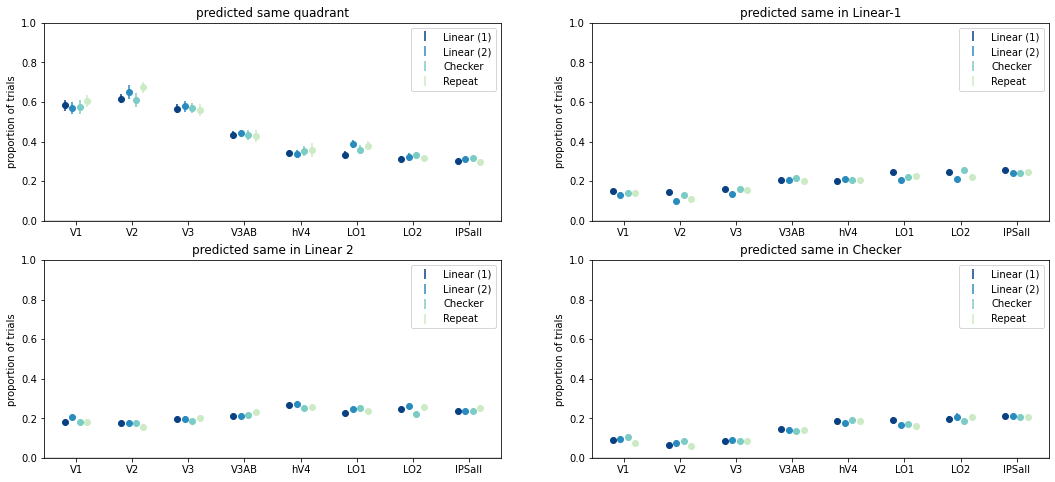

In [9]:
n_tot = np.sum(quad_confusion_bytype, axis=4, keepdims=True)
prop_each_type = quad_confusion_bytype / np.tile(n_tot, [1,1,1,1,4])

# average over all quadrants
propvals = np.mean(prop_each_type, axis=3)
propvals.shape

ti_plot = [0,1,2,3]

x_jitter = np.linspace(-0.2, 0.2, len(ti_plot))

plt.figure(figsize=(18,8))

for tyi, typename in enumerate(typenames):
    
    plt.subplot(2,2,tyi+1)
    plt.axhline(0, color=[0.8, 0.8, 0.8])

    lh = []

    for tii, ti in enumerate(ti_plot):

        x_ticks = np.arange(n_rois) + x_jitter[tii]

        vals = propvals[:,:,ti,tyi]
        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0) / np.sqrt(n_subjects)
        
        plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti])
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)

    plt.ylim([0, 1.0])
    # plt.ylim([-0.5, 0.5])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('proportion of trials')

    plt.legend(lh,task_names)

    plt.title('predicted %s'%typename)

#### plot confusion matrices for quadrants

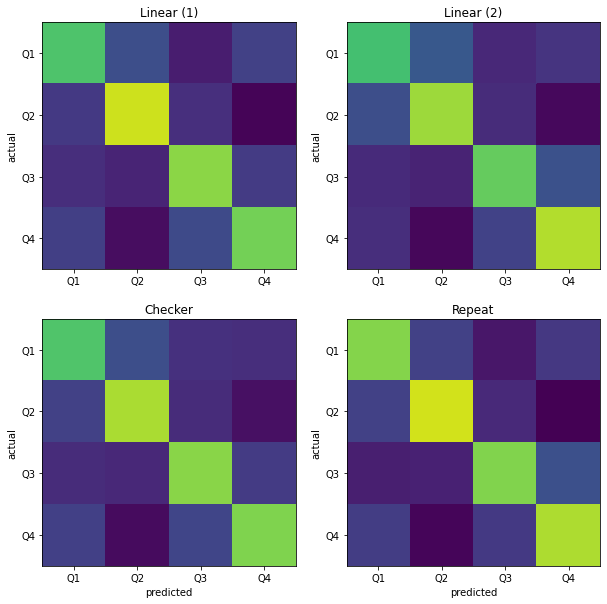

In [10]:
ri = 0;
plt.figure(figsize=(10,10))

for ti in range(4):
    
    counts = np.sum(quad_confusion[:,ri,ti,:,:], axis=0)
    sum_actual = np.sum(counts, axis=1, keepdims=True)
    props = counts/np.tile(sum_actual, [1,4])
    
    plt.subplot(2,2,ti+1)
    plt.pcolormesh(props,vmin=0.05, vmax=0.7)
    plt.gca().invert_yaxis()
    
    plt.xticks(np.arange(4)+0.5, ['Q%d'%q for q in quads])
    plt.yticks(np.arange(4)+0.5, ['Q%d'%q for q in quads])
    plt.ylabel('actual')
    if ti>1:
        plt.xlabel('predicted')
    
    plt.title(task_names[ti])

#### create templates

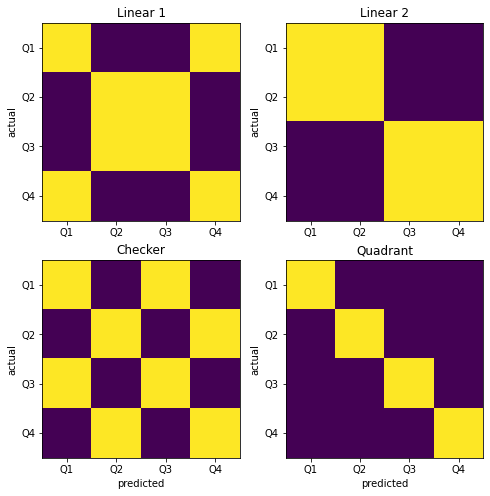

In [11]:
template_names = ['Linear 1','Linear 2','Checker','Quadrant']
n_templates = 4;

n_quads = 4;
ideal_conf_matrices = np.zeros((n_quads,n_quads, n_templates))

for qq in [0,1,2,3]:
    ideal_conf_matrices[qq,qq,:] = 1

for ti in range(3):

    for qg in quad_groups[ti]:

        ideal_conf_matrices[qg[0]-1,qg[1]-1,ti] = 1
        ideal_conf_matrices[qg[1]-1,qg[0]-1,ti] = 1

    
plt.figure(figsize=(8,8))

for ti in range(n_templates):
    
    plt.subplot(2,2,ti+1)
    plt.pcolormesh(ideal_conf_matrices[:,:,ti])
    plt.axis('square')
    
    plt.gca().invert_yaxis()
    
    plt.xticks(np.arange(4)+0.5, ['Q%d'%q for q in quads])
    plt.yticks(np.arange(4)+0.5, ['Q%d'%q for q in quads])
    plt.ylabel('actual')
    
    if ti>1:
        plt.xlabel('predicted')
    
        
    plt.title('%s'%template_names[ti])

#### compare actual confusions to templates

In [19]:
sim_each = np.zeros((n_subjects, n_rois, n_tasks, n_templates))

for si in range(n_subjects):

    for ri in range(n_rois):

        for ti in range(4):

            # divide counts by total trials in each quadrant
            counts = quad_confusion[si,ri,ti,:,:]
            sum_actual = np.sum(counts, axis=1, keepdims=True)
            props = counts/np.tile(sum_actual, [1,4])

            for tmpi in range(4):

                template = ideal_conf_matrices[:,:,tmpi]

                sim_each[si,ri,ti,tmpi] = np.corrcoef(props.ravel(), template.ravel())[0,1]

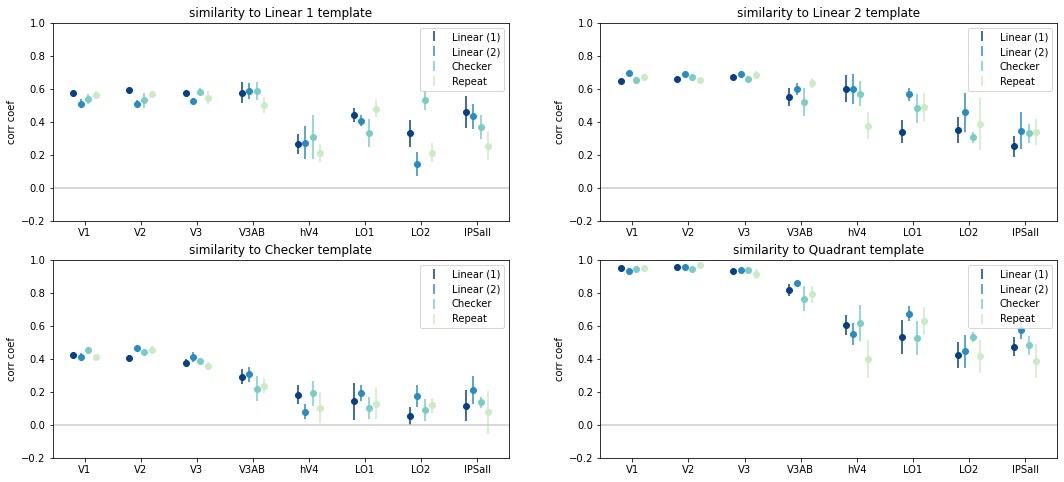

In [20]:
plt.figure(figsize=(18,8))

ti_plot = [0,1,2,3]

x_jitter = np.linspace(-0.2, 0.2, len(ti_plot))

for tmpi, tmpname in enumerate(template_names):
    
    plt.subplot(2,2, tmpi+1)
    
    plt.axhline(0, color=[0.8, 0.8, 0.8])

    lh = []

    for tii, ti in enumerate(ti_plot):

        x_ticks = np.arange(n_rois) + x_jitter[tii]

        vals = sim_each[:,:,ti,tmpi]
        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0) / np.sqrt(n_subjects)
        
        plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti])
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)

    plt.ylim([-0.2, 1.0])
    # plt.ylim([-0.5, 0.5])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('corr coef')

    plt.legend(lh,task_names)

    plt.title('similarity to %s template'%tmpname)


#### plotting two linear tasks only

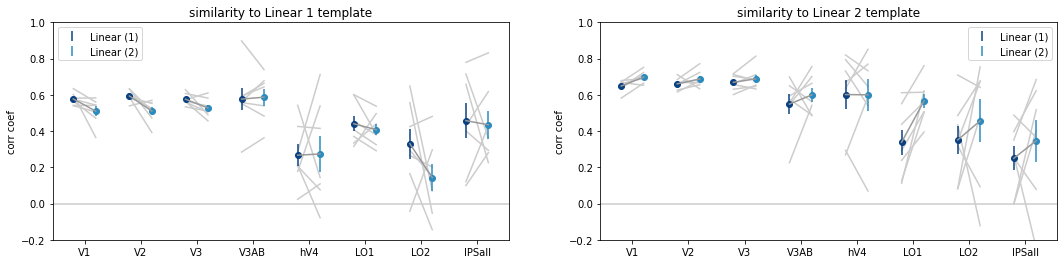

In [21]:
plt.figure(figsize=(18,4))

ti_plot = [0,1]

x_jitter = np.linspace(-0.2, 0.2, len(ti_plot))

for tmpi, tmpname in enumerate(template_names[0:2]):
    
    plt.subplot(1,2,tmpi+1)
    plt.axhline(0, color=[0.8, 0.8, 0.8])

    lh = []

    for tii, ti in enumerate(ti_plot):

        x_ticks = np.arange(n_rois) + x_jitter[tii]

        vals = sim_each[:,:,ti,tmpi]
        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0) / np.sqrt(n_subjects)
        
        plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti])
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)

    for ri in range(n_rois):
            
        meanvals = np.mean(sim_each[:,ri,ti_plot,tmpi], axis=0)
        plt.plot(ri+x_jitter, meanvals,'-',color=[0.6, 0.6, 0.6])

        plt.plot(ri+x_jitter, sim_each[:,ri,ti_plot,tmpi].T, color=[0.8, 0.8, 0.8], zorder=-10)

    plt.ylim([-0.2, 1.0])
    # plt.ylim([-0.5, 0.5])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('corr coef')

    plt.legend(lh,task_names)

    plt.title('similarity to %s template'%tmpname)

In [17]:
ti_plot = [0,1]


for tmpi, tmpname in enumerate(template_names[0:2]):

    vals = copy.deepcopy(sim_each[:,:,ti_plot,tmpi])

    tstats = np.zeros((n_rois,),dtype=float)
    pvals = np.zeros((n_rois,),dtype=float)

    n_subs_samedir = np.zeros((n_rois,),dtype=int)

    rndseed = 2343434
    for rr in range(n_rois):
        
        vals1 = vals[:,rr,0]
        vals2 = vals[:,rr,1]

        p, t = stats_utils.paired_ttest_nonpar(vals1, vals2, \
                                               n_iter=10000, rndseed=rndseed)    
        pvals[rr] = p
        tstats[rr] = t;

        subj_diffs = vals1 - vals2
        n_subs_samedir[rr] = np.maximum(np.sum(subj_diffs>0), np.sum(subj_diffs<0))

    print('\nsimilarity to %s template'%tmpname)
    task_df = pd.DataFrame({'t-stat for task 1 > task 2': tstats, \
                            'pvalue': pvals, \
                               'n_subs_indiv': n_subs_samedir}, \
                              index=roi_names)
    print(task_df.round(3))


similarity to Linear 1 template
        t-stat for task 1 > task 2  pvalue  n_subs_indiv
V1                           2.156   0.044             6
V2                           2.704   0.069             6
V3                           2.194   0.072             6
V3AB                        -0.291   0.770             4
hV4                         -0.057   0.956             4
LO1                          0.657   0.531             5
LO2                          1.451   0.206             5
IPSall                       0.214   0.874             4

similarity to Linear 2 template
        t-stat for task 1 > task 2  pvalue  n_subs_indiv
V1                          -3.220   0.047             6
V2                          -1.286   0.225             5
V3                          -1.066   0.365             4
V3AB                        -0.713   0.516             4
hV4                          0.019   1.003             4
LO1                         -3.596   0.017             7
LO2                   

In [18]:
ti_plot = [0,1]

x_jitter = np.linspace(-0.2, 0.2, len(ti_plot))

for tmpi, tmpname in enumerate(template_names[0:2]):

    vals = copy.deepcopy(sim_each[:,:,ti_plot, tmpi])

    anova_result = stats_utils.rmanova_2way(vals, ['roi','task'], do_shuffle=False)

    anova_result['Pr > F'] = anova_result['Pr > F'].round(4)

    print('\nAnova for similarity to %s template'%(tmpname))
    print(anova_result)



Anova for similarity to Linear 1 template
           F Value  Num DF  Den DF  Pr > F
roi       8.164544     7.0    42.0  0.0000
task      2.295027     1.0     6.0  0.1806
roi:task  0.730177     7.0    42.0  0.6474

Anova for similarity to Linear 2 template
           F Value  Num DF  Den DF  Pr > F
roi       8.987200     7.0    42.0  0.0000
task      6.135054     1.0     6.0  0.0480
roi:task  0.680002     7.0    42.0  0.6879
